<a href="https://colab.research.google.com/github/flyaflya/persuasive/blob/main/demoNotebooks/MultiLevelChapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
# ! pip install numpyro matplotlib seaborn daft arviz --upgrade

In [169]:
import xarray as xr
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [170]:
url = "https://raw.githubusercontent.com/flyaflya/persuasive/main/gym.csv"
gymDF = pd.read_csv(url)
gymDF.head(10)

,gymID,timePeriod,nTrialCustomers,nSigned,yogaStretch
0,1,1,32,7,0
1,2,1,56,4,0
2,3,1,42,1,0
3,4,1,58,9,0
4,5,1,84,44,0
5,1,2,38,14,0
6,2,2,68,7,0
7,3,2,42,3,0
8,4,2,64,13,0
9,5,2,72,33,0


In [171]:
(  ## open parenthesis to start readable code
    gymDF
    .groupby("gymID") ## split into group of df's, one for each gym
    .size() ## count # of rows in each and recombine into single df
) ## close parenthesis finishes the "method chaining"

gymID
1     5
2     5
3     5
4     5
5     5
6     4
7     4
8     4
9     3
10    2
11    1
12    1
dtype: int64

$$
\begin{aligned}
\textrm{Chosen } Geometry &= interval &(\mathtt{ax.barh})\\
\hline\\
\textrm{Gym} &\rightarrow \textrm{facet} &(\mathtt{axs[0,0] \ldots axs[3,4]})\\
\textrm{Time Period} &\rightarrow \textrm{horizontal postion } &(\mathtt{width})\\
\textrm{# of Trial Customers} &\rightarrow \textrm{vertical postion} &(\mathtt{y})\\
\textrm{# of Customers Converted To Members} &\rightarrow \textrm{vertical postion} &(\mathtt{y})\\
\textrm{Yoga Stretch Indicator} &\rightarrow \textrm{color } &(\mathtt{color})
\end{aligned}
$$


In [172]:
## just plot gym 1 and then figure out how to create a facet for each gym

gym1DF = (  ## open parenthesis to start readable code
    gymDF
    .query("gymID == 1")
)

gym1DF

,gymID,timePeriod,nTrialCustomers,nSigned,yogaStretch
0,1,1,32,7,0
5,1,2,38,14,0
13,1,3,31,16,1
22,1,4,30,13,1
32,1,5,29,12,1


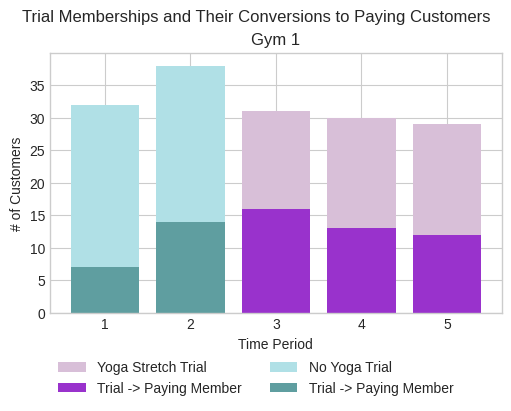

In [173]:
fig, ax = plt.subplots(figsize = [5,3.5], layout = "constrained")
fig.suptitle("Trial Memberships and Their Conversions to Paying Customers")

ax.set_title("Gym 1")
ax.set_xlabel("Time Period")
ax.set_ylabel("# of Customers")

## plot different bars for yoga stretch and not yoga stretch
for timePeriod, nTrialCustomers, nSigned, yogaStretch in zip(gym1DF.timePeriod, gym1DF.nTrialCustomers, gym1DF.nSigned, gym1DF.yogaStretch):
    if yogaStretch == 1:
        yogaTrial = ax.bar(timePeriod, nTrialCustomers, color = "thistle", label = "Yoga Stretch Trial")
        yogaMember = ax.bar(timePeriod, nSigned, color = "darkorchid", label = "Trial -> Paying Member")
    else:
        noYogaTrial = ax.bar(timePeriod, nTrialCustomers, color = "powderblue", label = "No Yoga Trial")
        noYogaMember = ax.bar(timePeriod, nSigned, color = "cadetblue", label = "Trial -> Paying Member")

fig.legend(handles = [yogaTrial, yogaMember, noYogaTrial, noYogaMember], bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol = 2)

plt.show()

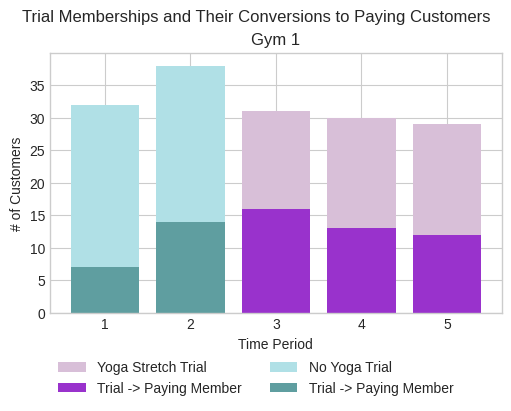

In [174]:
import matplotlib.pyplot as plt

gymGroupedDF = gymDF.groupby("gymID")
gym1DF = gymGroupedDF.get_group(1)

fig, ax = plt.subplots(figsize = [5,3.5], layout = "constrained")

# labels to help our audience
fig.suptitle("Trial Memberships and Their Conversions to Paying Customers")
ax.set_title("Gym 1")
ax.set_xlabel("Time Period")
ax.set_ylabel("# of Customers")

## plot different bars for yoga stretch and not yoga stretch
for time, nTrials, nSigned, yogaStretch in zip(
  gym1DF.timePeriod, 
  gym1DF.nTrialCustomers, 
  gym1DF.nSigned, 
  gym1DF.yogaStretch
):
    if yogaStretch == 1:
        yogaTrial = ax.bar(
          time, nTrials, color = "thistle", 
          label = "Yoga Stretch Trial")
        yogaMember = ax.bar(
          time, nSigned, color = "darkorchid", 
          label = "Trial -> Paying Member")
    else:
        noYogaTrial = ax.bar(
          time, nTrials, color = "powderblue",
          label = "No Yoga Trial")
        noYogaMember = ax.bar(
          time, nSigned, color = "cadetblue", 
          label = "Trial -> Paying Member")

fig.legend(
  handles = [yogaTrial, yogaMember, noYogaTrial, noYogaMember],
  bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol = 2)

plt.show()

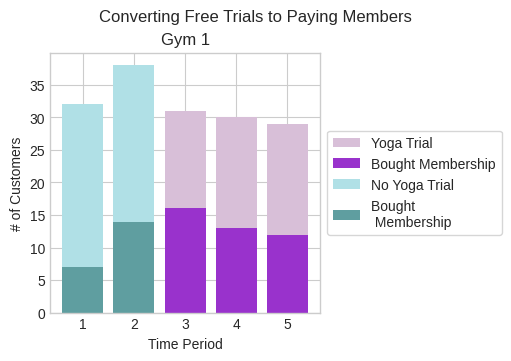

In [175]:
import matplotlib.pyplot as plt

# get just gym 1
gymGroupedDF = gymDF.groupby("gymID")
grpDF = gymGroupedDF.get_group(1)

fig, ax = plt.subplots(figsize = [5,3.5], layout = "constrained")

# labels to help our audience
fig.suptitle("Converting Free Trials to Paying Members")
ax.set_title("Gym 1")
ax.set_xlabel("Time Period")
ax.set_ylabel("# of Customers")

# create boolean masks to filter the rows by yogaStretch value
has_yoga = grpDF["yogaStretch"] == 1
no_yoga = grpDF["yogaStretch"] == 0

# plot the bars for each group separately
yogaTrial = ax.bar(
  grpDF.loc[has_yoga, "timePeriod"], 
  grpDF.loc[has_yoga, "nTrialCustomers"], 
  color = "thistle", 
  label = "Yoga Trial"
)

yogaMember = ax.bar(
  grpDF.loc[has_yoga, "timePeriod"], 
  grpDF.loc[has_yoga, "nSigned"], 
  color = "darkorchid", 
  label = "Bought Membership"
)

noYogaTrial = ax.bar(
  grpDF.loc[no_yoga, "timePeriod"], 
  grpDF.loc[no_yoga, "nTrialCustomers"], 
  color = "powderblue",
  label = "No Yoga Trial"
)

noYogaMember = ax.bar(
  grpDF.loc[no_yoga, "timePeriod"], 
  grpDF.loc[no_yoga, "nSigned"], 
  color = "cadetblue", 
  label = "Bought \n Membership"
)

ax.legend(
  handles = [yogaTrial, yogaMember, noYogaTrial, noYogaMember],
  bbox_to_anchor=(1, 0.5), loc='center left', ncol = 1,
  frameon=True, facecolor='white'
)

plt.show()

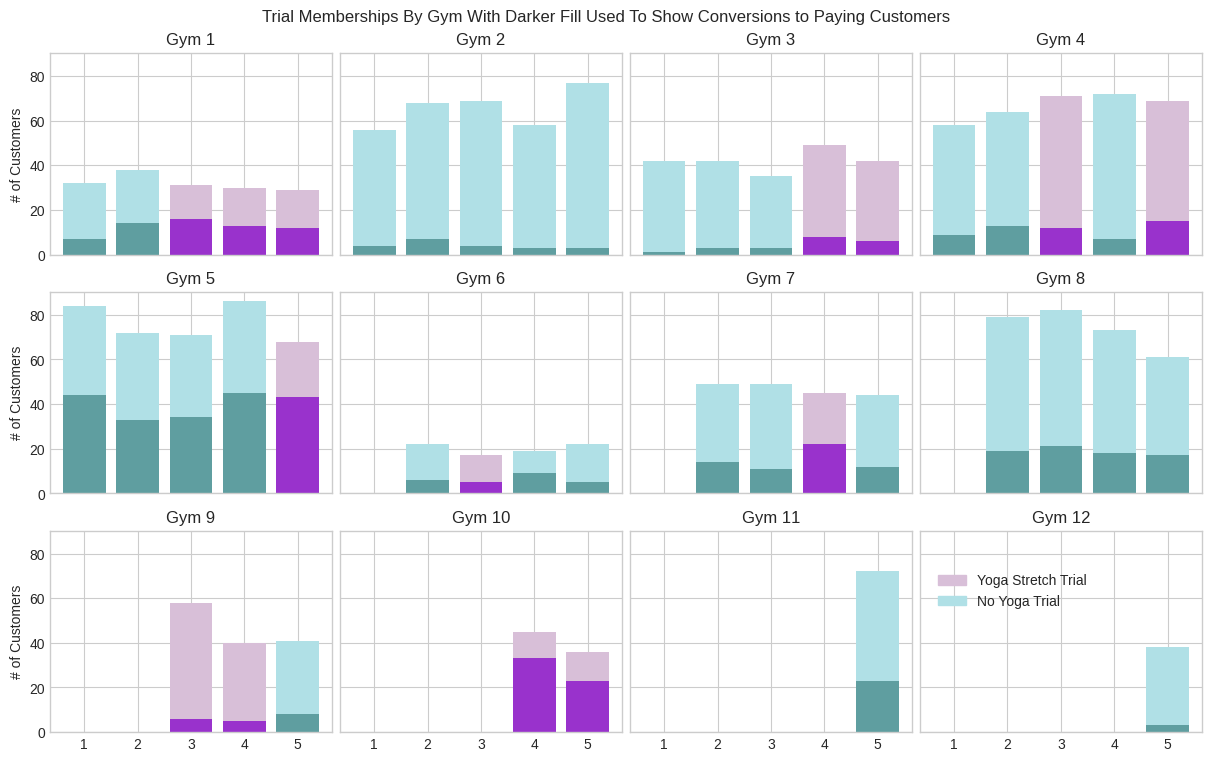

In [176]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# compute number of gyms for laying out figure
numGyms = gymDF['gymID'].nunique()

# create enough subplots (assume four columns)
num_cols = 4
num_rows = (numGyms - 1) // num_cols + 1  ## // is floor division

# create figure
fig, axes = plt.subplots(
  nrows=num_rows, 
  ncols=num_cols, 
  sharex = True, 
  sharey = True, 
  figsize=(12, 2.5*num_rows), 
  layout = "constrained")
  
fig.suptitle("Trial Memberships By Gym With Darker Fill Used To Show Conversions to Paying Customers")

# iterate through gyms creating bar plots left to right with four columns
for i, (gymID, grpDF) in enumerate(gymGroupedDF):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.set_title(f'Gym {gymID}')
    if row == num_rows:
        ax.set_xlabel("Time Period")
    if col == 0:
        ax.set_ylabel("# of Customers")
    # create boolean masks to filter the rows by yogaStretch value
    has_yoga = grpDF["yogaStretch"] == 1
    no_yoga = grpDF["yogaStretch"] == 0

    ## same code as above, just using gymDF
    # create bars for yoga and non-yoga trials
    yogaTrial2 = ax.bar(
        grpDF.loc[has_yoga, 'timePeriod'],
        grpDF.loc[has_yoga, 'nTrialCustomers'],
        color='thistle',
        label='Yoga Stretch Trial'
    )
    noYogaTrial = ax.bar(
        grpDF.loc[no_yoga, 'timePeriod'],
        grpDF.loc[no_yoga, 'nTrialCustomers'],
        color='powderblue',
        label='No Yoga Trial'
    )
    
    # create bars for yoga and non-yoga paying members
    ax.bar(
        grpDF.loc[has_yoga, 'timePeriod'],
        grpDF.loc[has_yoga, 'nSigned'],
        color='darkorchid'
    )
    ax.bar(
        grpDF.loc[no_yoga, 'timePeriod'],
        grpDF.loc[no_yoga, 'nSigned'],
        color='cadetblue'
    )

# use patch objects for the legend
yogaTrialPatch = mpatches.Patch(color='thistle', label='Yoga Stretch Trial')
noYogaTrialPatch = mpatches.Patch(color='powderblue', label='No Yoga Trial')

# place legend in bottom-right box where there is white space
ax = axes[2, 3]
ax.legend(
  handles = [yogaTrialPatch, noYogaTrialPatch],
  bbox_to_anchor=(0.02, 0.7), loc='center left', ncol = 1
)
plt.show()

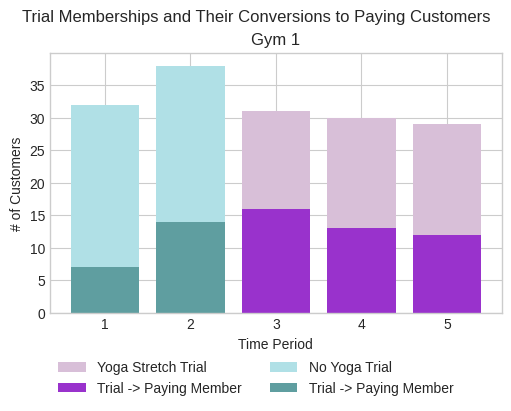

In [177]:
import matplotlib.pyplot as plt

gymGroupedDF = gymDF.groupby("gymID")
gym1DF = gymGroupedDF.get_group(1)

fig, ax = plt.subplots(figsize = [5,3.5], layout = "constrained")

# labels to help our audience
fig.suptitle("Trial Memberships and Their Conversions to Paying Customers")
ax.set_title("Gym 1")
ax.set_xlabel("Time Period")
ax.set_ylabel("# of Customers")

# create bars for yoga and non-yoga trials
yogaTrial = ax.bar(
    gym1DF.loc[gym1DF.yogaStretch == 1, 'timePeriod'],
    gym1DF.loc[gym1DF.yogaStretch == 1, 'nTrialCustomers'],
    color='thistle',
    label='Yoga Stretch Trial'
)
noYogaTrial = ax.bar(
    gym1DF.loc[gym1DF.yogaStretch == 0, 'timePeriod'],
    gym1DF.loc[gym1DF.yogaStretch == 0, 'nTrialCustomers'],
    color='powderblue',
    label='No Yoga Trial'
)

# create bars for yoga and non-yoga paying members
yogaMember = ax.bar(
    gym1DF.loc[gym1DF.yogaStretch == 1, 'timePeriod'],
    gym1DF.loc[gym1DF.yogaStretch == 1, 'nSigned'],
    color='darkorchid',
    label='Trial -> Paying Member'
)
noYogaMember = ax.bar(
    gym1DF.loc[gym1DF.yogaStretch == 0, 'timePeriod'],
    gym1DF.loc[gym1DF.yogaStretch == 0, 'nSigned'],
    color='cadetblue',
    label='Trial -> Paying Member'
)

fig.legend(
  handles = [yogaTrial, yogaMember, noYogaTrial, noYogaMember],
  bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol = 2
)

plt.show()


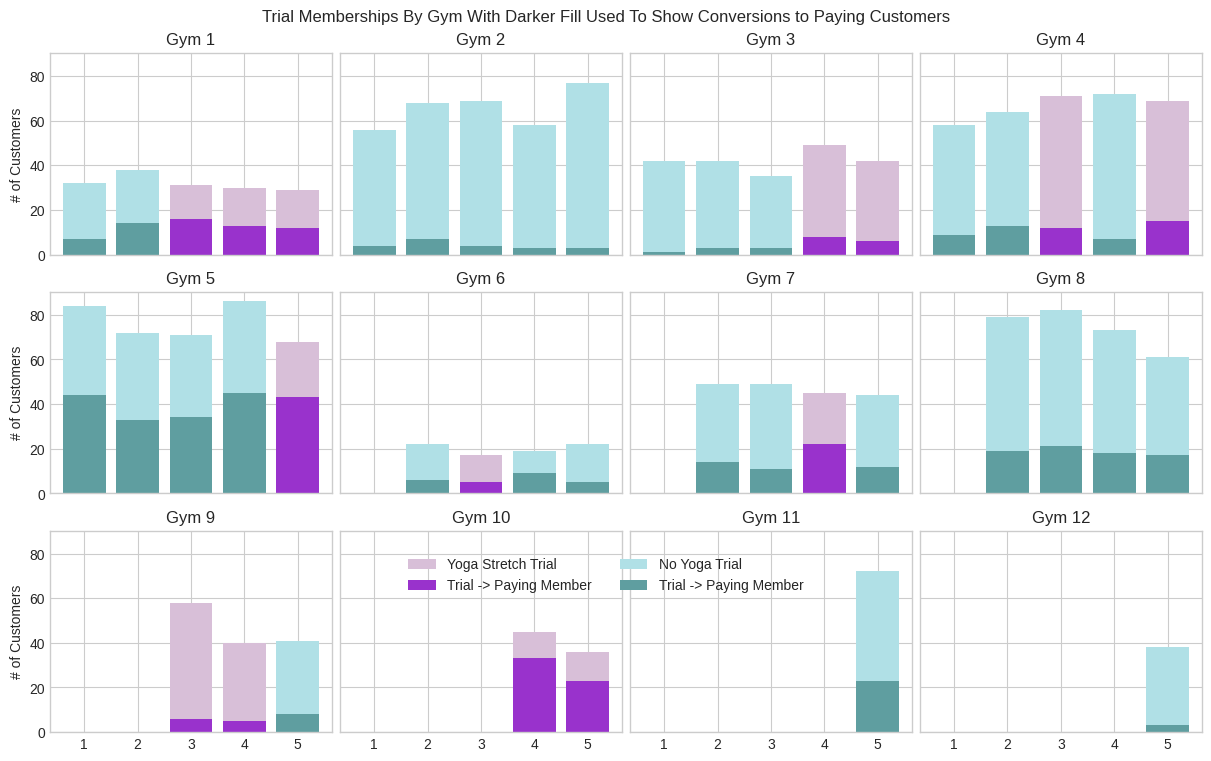

In [178]:
# now let's groupby and iterate over each gym's data to a better figure including all gym data

# create pandas groupby object
gymGroupedDF = gymDF.groupby("gymID")

# compute number of gyms for laying out figure
numGyms = gymDF['gymID'].nunique()

# create enough subplots (assume four columns)
num_cols = 4
num_rows = (numGyms - 1) // num_cols + 1

# create figure
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex = True, sharey = True, figsize=(12, 2.5*num_rows), layout = "constrained")
fig.suptitle("Trial Memberships By Gym With Darker Fill Used To Show Conversions to Paying Customers")

# iterate through gyms creating bar plots left to right with four columns
for i, (gymID, grpDF) in enumerate(gymGroupedDF):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.set_title(f'Gym {gymID}')
    if row == num_rows:
        ax.set_xlabel("Time Period")
    if col == 0:
        ax.set_ylabel("# of Customers")

    ## same code as above, just using gymDF
    for timePeriod, nTrialCustomers, nSigned, yogaStretch in zip(grpDF.timePeriod, grpDF.nTrialCustomers, grpDF.nSigned, grpDF.yogaStretch):
        if yogaStretch == 1:
            yogaTrial = ax.bar(timePeriod, nTrialCustomers, color = "thistle", label = "Yoga Stretch Trial")
            yogaMember = ax.bar(timePeriod, nSigned, color = "darkorchid", label = "Trial -> Paying Member")
        else:
            noYogaTrial = ax.bar(timePeriod, nTrialCustomers, color = "powderblue", label = "No Yoga Trial")
            noYogaMember = ax.bar(timePeriod, nSigned, color = "cadetblue", label = "Trial -> Paying Member")

fig.legend(handles = [yogaTrial, yogaMember, noYogaTrial, noYogaMember], bbox_to_anchor=(0.5, 0.2), loc='lower center', ncol = 2)
plt.show()

In [179]:
gymDF

,gymID,timePeriod,nTrialCustomers,nSigned,yogaStretch
0,1,1,32,7,0
1,2,1,56,4,0
2,3,1,42,1,0
3,4,1,58,9,0
4,5,1,84,44,0
5,1,2,38,14,0
6,2,2,68,7,0
7,3,2,42,3,0
8,4,2,64,13,0
9,5,2,72,33,0


In [180]:
(
    gymDF
    .groupby("yogaStretch")
    .sum()
    .assign(pctSuccess = lambda DF: DF.nSigned / DF.nTrialCustomers)
)

,gymID,timePeriod,nTrialCustomers,nSigned,pctSuccess
yogaStretch,,,,,
0,156,91,1675,400,0.238806
1,73,57,630,219,0.347619


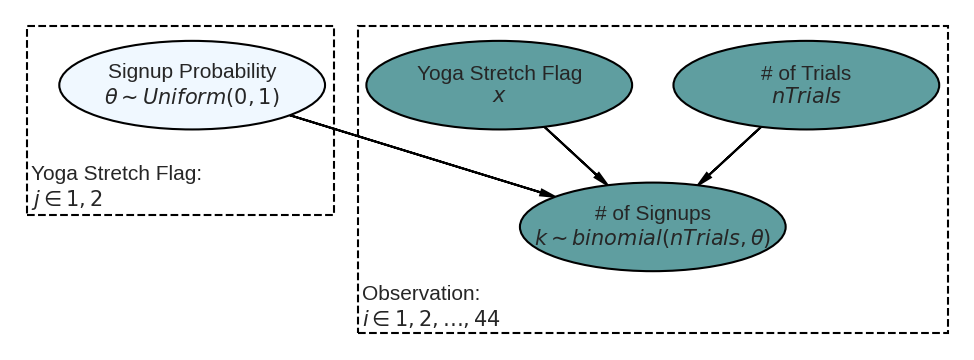

In [181]:
## make a DAG
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial, partialmethod
import daft   ### %pip install -U git+https://github.com/daft-dev/daft.git
from numpy.random import default_rng
import numpy as np

class dag(daft.PGM):
    def __init__(self, *args, **kwargs):
        daft.PGM.__init__(self, *args, **kwargs)
    
    obsNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 1.6, fontsize = 10, plot_params = {'facecolor': 'cadetblue'})
    decNode = partialmethod(daft.PGM.add_node, aspect = 2.2, fontsize = 10, shape = "rectangle", plot_params = {'facecolor': 'thistle'})
    detNode = partialmethod(daft.PGM.add_node, aspect = 5.4, fontsize = 9.25, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 1.6, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    detNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.25, fontsize = 10, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.2, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    
pgm = dag(dpi = 300, alternate_style="outer")
pgm.obsNode("k","# of Signups\n"+r"$k \sim binomial(nTrials,\theta)$",1.3,1, scale = 1.5, aspect = 3)
pgm.obsNode("x","Yoga Stretch Flag\n"+r"$x$",0,2.2, scale = 1.5, aspect = 3)
pgm.obsNode("nTrials","# of Trials\n"+r"$nTrials$",2.6,2.2, scale = 1.5, aspect = 3)
pgm.latNode("theta","Signup Probability\n"+r"$\theta \sim Uniform(0,1)$",-2.6,2.2, scale = 1.5, aspect = 3)
pgm.add_edge("theta","k")
pgm.add_edge("nTrials","k")
pgm.add_edge("x","k")
pgm.add_plate([-1.2, 0.1, 5.0, 2.6], label = "Observation:\n" + r"$i \in 1, 2, \ldots, 44$", 
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "black"}))
pgm.add_plate([-4.0, 1.1, 2.6, 1.6], label = "Yoga Stretch Flag:\n" + r"$j \in 1, 2$", 
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "black"}))
pgm.show(dpi = 150)

In [182]:
## making a numpyro model
import numpy as np
import numpyro
import numpyro.distributions as dist
import arviz as az
from jax import random
from numpyro.infer import MCMC, NUTS

## define the graphical/statistical model as a Python function
## for posterior predictive checks, we introduce numObs argument
## which here represents len(k), the # of observations
def completePoolingModel(x, nTrials, k, numObs):
    with numpyro.plate('yogaPlate', 2):
        theta = numpyro.sample('theta', dist.Beta(concentration1=2, #alpha
                                              concentration0=2)) #beta
    ## recall yoga flag defintions
    ## p_other, p_yoga = p[0], p[1]

    with numpyro.plate('observation', numObs):
        k = numpyro.sample('k', dist.Binomial(total_count = nTrials, probs = theta[x]), obs=k)

## computationally get posterior distribution
mcmc = MCMC(NUTS(completePoolingModel), num_warmup=500, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(
    rng_key, 
    x = gymDF.yogaStretch.values, 
    nTrials = gymDF.nTrialCustomers.values, 
    k = gymDF.nSigned.values,
    numObs = len(gymDF.nSigned.values)
) ## get representative sample of posterior
drawsDS = az.from_numpyro(mcmc).posterior ## get posterior samples into xarray

sample: 100%|██████████| 4500/4500 [00:06<00:00, 681.23it/s, 3 steps of size 7.90e-01. acc. prob=0.92] 


In [183]:
postSamples = mcmc.get_samples()  ##get samples for posterior pred check
postSamples

{'theta': Array([[0.23336893, 0.3822349 ],
        [0.23881775, 0.3575459 ],
        [0.24461366, 0.3179841 ],
        ...,
        [0.23359278, 0.29059547],
        [0.23579717, 0.40755054],
        [0.24735093, 0.39213514]], dtype=float32)}

In [184]:
from numpyro.infer import Predictive
from jax import random
rng = random.PRNGKey(seed = 111)

## Predictive is a NumPyro class used to construct posterior distributions
predictiveObject = Predictive(model = completePoolingModel,posterior_samples = postSamples)

## now make posterior predictions
## use None for data so that it gets simulated from posterior draws
postPredData = predictiveObject(
    rng_key, 
    x = gymDF.yogaStretch.values, 
    nTrials = gymDF.nTrialCustomers.values, 
    k = None,  ### OMIT SIGNUP DATA SO IT GETS SIMULATED,
    numObs = len(gymDF.nSigned.values)
)
postPredData  ## for each of 4,000 draws, 
              ## get 44 simulated observations of gyms

{'k': Array([[ 8, 11,  5, ..., 13, 23, 10],
        [ 7, 13,  7, ..., 10, 18, 15],
        [ 8, 12,  8, ..., 10, 21,  7],
        ...,
        [ 6,  9, 13, ..., 14, 22, 12],
        [12, 14,  8, ..., 16, 17,  8],
        [ 7, 17, 11, ..., 10, 16, 12]], dtype=int32)}

<Axes: xlabel='k / k'>

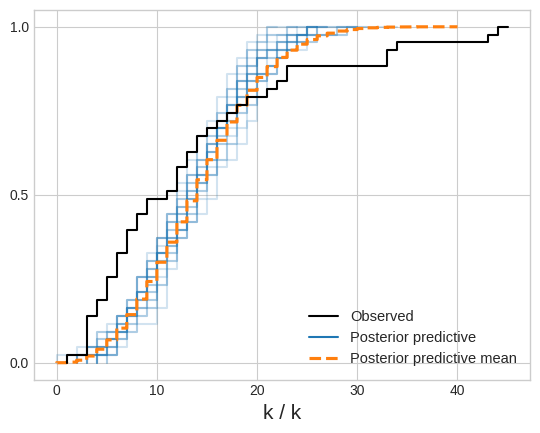

In [185]:
dataForArvizPlotting = az.from_numpyro(
    posterior = mcmc,
    posterior_predictive=postPredData
)
az.plot_ppc(dataForArvizPlotting, num_pp_samples=20, kind = "cumulative")
## mismatched bin widths is a limitation of plot_ppc(... kind = "kde"), so using cumulative instead

<Axes: xlabel='k / k'>

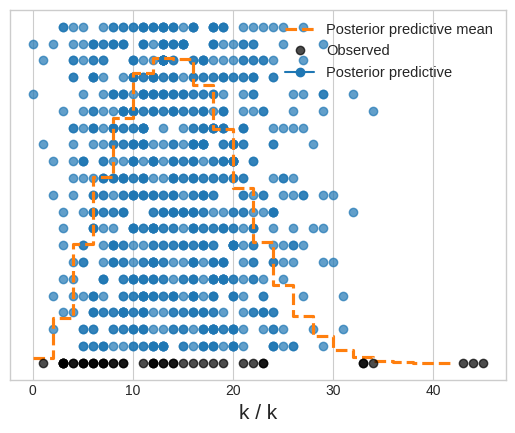

In [186]:
## you can also experiment with plot_ppc(... kind = "cumulative")
az.plot_ppc(dataForArvizPlotting, num_pp_samples=20, kind = "scatter")

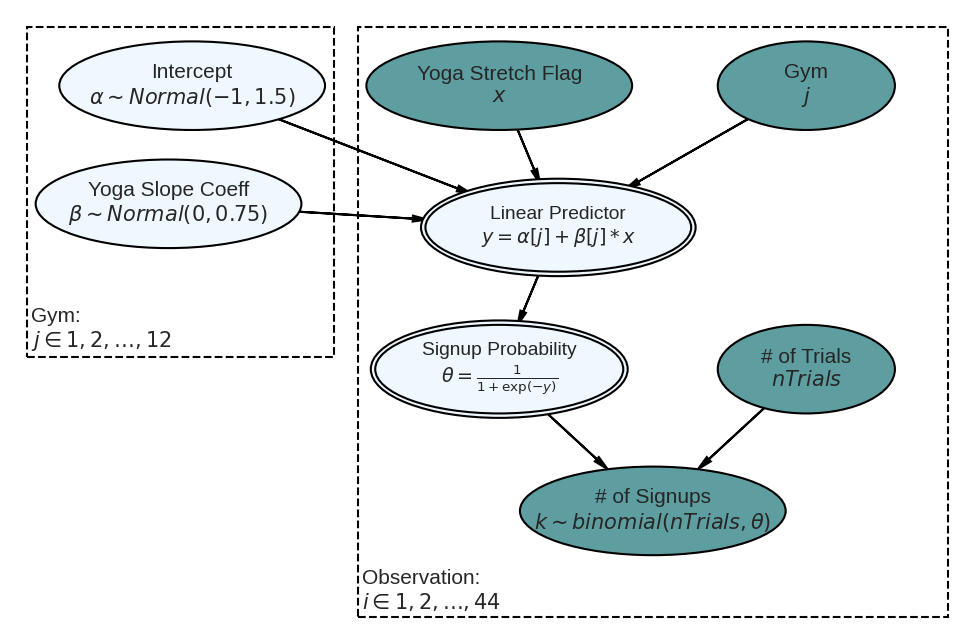

In [187]:
class dag(daft.PGM):
    def __init__(self, *args, **kwargs):
        daft.PGM.__init__(self, *args, **kwargs)
    
    obsNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 1.6, fontsize = 10, plot_params = {'facecolor': 'cadetblue'})
    decNode = partialmethod(daft.PGM.add_node, aspect = 2.2, fontsize = 10, shape = "rectangle", plot_params = {'facecolor': 'thistle'})
    detNode = partialmethod(daft.PGM.add_node, aspect = 5.4, fontsize = 9.25, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 1.6, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    detNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.25, fontsize = 10, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.2, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    
pgm = dag(dpi = 300, alternate_style="outer")
pgm.obsNode("k","# of Signups\n"+r"$k \sim binomial(nTrials,\theta)$",1.3,1, scale = 1.5, aspect = 3)
pgm.obsNode("x","Yoga Stretch Flag\n"+r"$x$",0,4.6, scale = 1.5, aspect = 3)
pgm.obsNode("j","Gym\n"+r"$j$",2.6,4.6, scale = 1.5, aspect = 2)
pgm.obsNode("nTrials","# of Trials\n"+r"$nTrials$",2.6,2.2, scale = 1.5, aspect = 2)
pgm.latNode("beta","Yoga Slope Coeff\n"+r"$\beta \sim Normal(0,0.75)$",-2.8,3.6, scale = 1.5, aspect = 3)
pgm.latNode("alpha","Intercept\n"+r"$\alpha \sim Normal(-1,1.5)$",-2.6,4.6, scale = 1.5, aspect = 3)
pgm.detNode("theta","Signup Probability\n"+r"$\theta = \frac{1}{1+\exp(-y)}$",0,2.2, scale = 1.5, aspect = 2.8)
pgm.detNode("y","Linear Predictor\n"+r"$y = \alpha [j] + \beta[j] * x}$",0.5,3.4, scale = 1.5, aspect = 3)
pgm.add_edge("theta","k")
pgm.add_edge("nTrials","k")
pgm.add_edge("x","y")
pgm.add_edge("alpha","y")
pgm.add_edge("beta","y")
pgm.add_edge("j","y")
pgm.add_edge("y","theta")
pgm.add_plate([-1.2, 0.1, 5.0, 5.0], label = "Observation:\n" + r"$i \in 1, 2, \ldots, 44$", 
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "black"}))
pgm.add_plate([-4.0, 2.3, 2.6, 2.8], label = "Gym:\n" + r"$j \in 1, 2, \ldots, 12$", 
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "black"}))
pgm.show(dpi = 150)



In [188]:
from jax.scipy.special import expit as invLogit ## from JAX package, not scipy

def noPoolingModel(x, j, nTrials, k, numObs):
    with numpyro.plate('gym', len(np.unique(j))):
        alpha = numpyro.sample('alpha', dist.Normal(-1,1.5))
        beta = numpyro.sample('beta', dist.Normal(0,0.75))

    with numpyro.plate('observation', numObs):
        y = numpyro.deterministic('y', alpha[j] + beta[j] * x)
        theta = numpyro.deterministic('theta', invLogit(y))
        k = numpyro.sample('k', dist.Binomial(total_count = nTrials, probs = theta), obs=k)

## computationally get posterior distribution
mcmc = MCMC(NUTS(noPoolingModel), num_warmup=500, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(
    rng_key, 
    x = gymDF.yogaStretch.values,
    j = pd.factorize(gymDF.gymID.values)[0], ## ensure compatibility with python 
                                             ## zero-based indexing
    nTrials = gymDF.nTrialCustomers.values, 
    k = gymDF.nSigned.values,
    numObs = len(gymDF.nSigned.values)
) ## get representative sample of posterior
drawsDS = az.from_numpyro(mcmc).posterior ## get posterior samples into xarray
## careful to restore original id's for the gyms
drawsDS = az.from_numpyro(mcmc,
                coords={"gym": pd.factorize(gymDF.gymID.values)[1],
                        "observation":  np.arange(len(gymDF.nSigned.values))},
                dims={"alpha": ["gym"],
                      "beta": ["gym"],
                      "theta": ["observation"],
                      "y": ["observation"]}
                ) ## get posterior samples into xarray

sample: 100%|██████████| 4500/4500 [00:05<00:00, 752.61it/s, 15 steps of size 2.36e-01. acc. prob=0.93] 


In [189]:
az.from_numpyro(mcmc).posterior

<xarray.Dataset>
Dimensions:      (chain: 1, draw: 4000, alpha_dim_0: 12, beta_dim_0: 12,
                  theta_dim_0: 44, y_dim_0: 44)
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * alpha_dim_0  (alpha_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * beta_dim_0   (beta_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7 ... 36 37 38 39 40 41 42 43
  * y_dim_0      (y_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 36 37 38 39 40 41 42 43
Data variables:
    alpha        (chain, draw, alpha_dim_0) float32 -1.1 -2.829 ... -2.731
    beta         (chain, draw, beta_dim_0) float32 1.003 1.392 ... 0.5273 0.9958
    theta        (chain, draw, theta_dim_0) float32 0.2497 0.05579 ... 0.06115
    y            (chain, draw, y_dim_0) float32 -1.1 -2.829 ... -0.965 -2.731
Attributes:
    created_at:                 2023-04-13T20:56:10.536951
    arviz_version:              0.15.1
    inference_library:          numpyro
    inference_library_version:  0.11.0

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

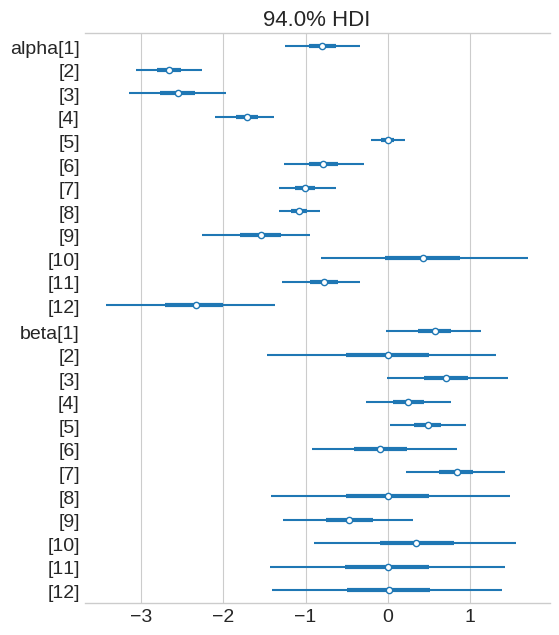

In [190]:
az.plot_forest(drawsDS, var_names = ["alpha","beta"])

<ipython-input-191-f32016c4091b>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


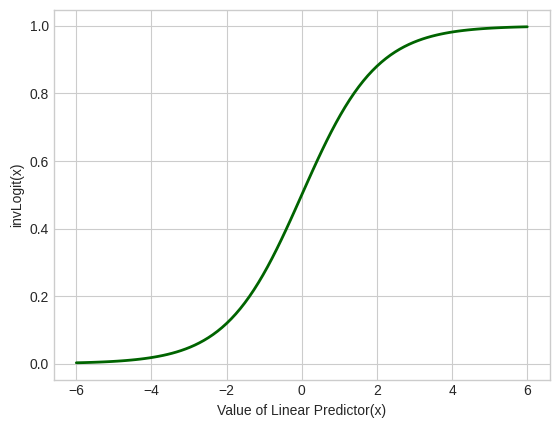

In [191]:
# Set the x-axis limits
x = np.linspace(-6, 6, 100)

fig, ax = plt.subplots()
ax.plot(x, invLogit(x), lw=2, color='DarkGreen')

# Set the x and y-axis labels
ax.set_xlabel('Value of Linear Predictor(x)')
ax.set_ylabel('invLogit(x)')

# Set the plot style to 'seaborn-whitegrid'
plt.style.use('seaborn-whitegrid')

# Show the plot
plt.show()

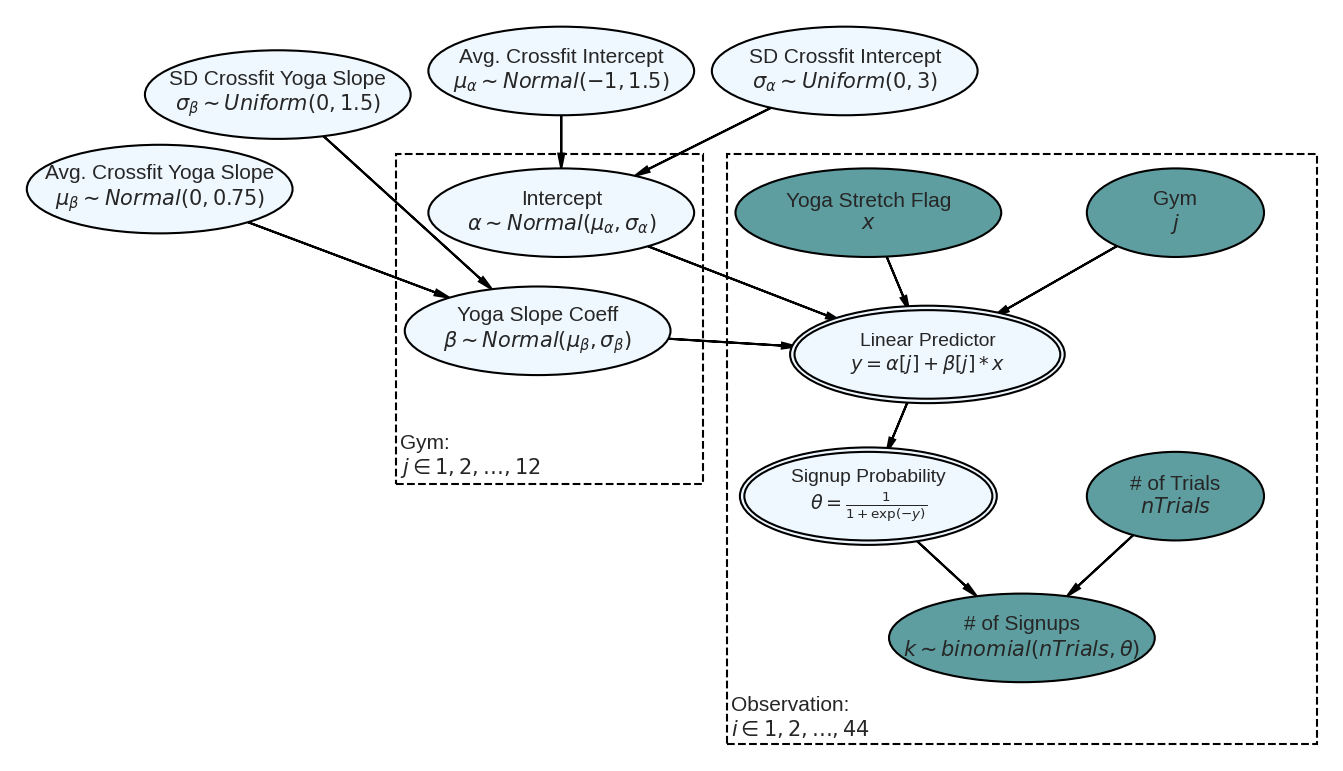

In [192]:
class dag(daft.PGM):
    def __init__(self, *args, **kwargs):
        daft.PGM.__init__(self, *args, **kwargs)
    
    obsNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 1.6, fontsize = 10, plot_params = {'facecolor': 'cadetblue'})
    decNode = partialmethod(daft.PGM.add_node, aspect = 2.2, fontsize = 10, shape = "rectangle", plot_params = {'facecolor': 'thistle'})
    detNode = partialmethod(daft.PGM.add_node, aspect = 5.4, fontsize = 9.25, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 1.6, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    detNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.25, fontsize = 10, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.2, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    
pgm = dag(dpi = 300, alternate_style="outer")
pgm.obsNode("k","# of Signups\n"+r"$k \sim binomial(nTrials,\theta)$",1.3,1, scale = 1.5, aspect = 3)
pgm.obsNode("x","Yoga Stretch Flag\n"+r"$x$",0,4.6, scale = 1.5, aspect = 3)
pgm.obsNode("j","Gym\n"+r"$j$",2.6,4.6, scale = 1.5, aspect = 2)
pgm.obsNode("nTrials","# of Trials\n"+r"$nTrials$",2.6,2.2, scale = 1.5, aspect = 2)
pgm.latNode("beta","Yoga Slope Coeff\n"+r"$\beta \sim Normal(\mu_{\beta},\sigma_{\beta})$",-2.8,3.6, scale = 1.5, aspect = 3)
pgm.latNode("alpha","Intercept\n"+r"$\alpha \sim Normal(\mu_{\alpha}, \sigma_{\alpha})$",-2.6,4.6, scale = 1.5, aspect = 3)
pgm.detNode("theta","Signup Probability\n"+r"$\theta = \frac{1}{1+\exp(-y)}$",0,2.2, scale = 1.5, aspect = 2.8)
pgm.detNode("y","Linear Predictor\n"+r"$y = \alpha [j] + \beta[j] * x}$",0.5,3.4, scale = 1.5, aspect = 3)
pgm.latNode("mu_alpha","Avg. Crossfit Intercept\n"+r"$\mu_{\alpha} \sim Normal(-1,1.5)$",-2.6,5.8, scale = 1.5, aspect = 3)
pgm.latNode("sd_alpha","SD Crossfit Intercept\n"+r"$\sigma_{\alpha} \sim Uniform(0,3)$",-0.2,5.8, scale = 1.5, aspect = 3)
pgm.latNode("sd_beta","SD Crossfit Yoga Slope\n"+r"$\sigma_{\beta} \sim Uniform(0,1.5)$",-5.0,5.6, scale = 1.5, aspect = 3)
pgm.latNode("mu_beta","Avg. Crossfit Yoga Slope\n"+r"$\mu_{\beta} \sim Normal(0,0.75)$",-6.0,4.8, scale = 1.5, aspect = 3)
pgm.add_edge("theta","k")
pgm.add_edge("nTrials","k")
pgm.add_edge("x","y")
pgm.add_edge("alpha","y")
pgm.add_edge("beta","y")
pgm.add_edge("j","y")
pgm.add_edge("y","theta")
pgm.add_edge("mu_alpha","alpha")
pgm.add_edge("sd_alpha","alpha")
pgm.add_edge("mu_beta","beta")
pgm.add_edge("sd_beta","beta")
pgm.add_plate([-1.2, 0.1, 5.0, 5.0], label = "Observation:\n" + r"$i \in 1, 2, \ldots, 44$", 
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "black"}))
pgm.add_plate([-4.0, 2.3, 2.6, 2.8], label = "Gym:\n" + r"$j \in 1, 2, \ldots, 12$", 
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "black"}))
pgm.show(dpi = 150)

In [193]:
def partialPoolingModel(x, j, nTrials, k, numObs):
    mu_alpha = numpyro.sample('mu_alpha', dist.Normal(-1,1.5))
    sd_alpha = numpyro.sample('sd_alpha', dist.Uniform(0,3))

    mu_beta = numpyro.sample('mu_beta', dist.Normal(0,0.75))
    sd_beta = numpyro.sample('sd_beta', dist.Uniform(0,1.5))

    with numpyro.plate('gym', len(np.unique(j))):
        alpha = numpyro.sample('alpha', dist.Normal(mu_alpha,sd_alpha))
        beta = numpyro.sample('beta', dist.Normal(mu_beta,sd_beta))

    with numpyro.plate('observation', numObs):
        y = numpyro.deterministic('y', alpha[j] + beta[j] * x)
        theta = numpyro.deterministic('theta', invLogit(y))
        k = numpyro.sample('k', dist.Binomial(total_count = nTrials, probs = theta), obs=k)

## computationally get posterior distribution
mcmc = MCMC(NUTS(partialPoolingModel), num_warmup=500, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(
    rng_key, 
    x = gymDF.yogaStretch.values,
    j = pd.factorize(gymDF.gymID.values)[0], ## ensure compatibility with python 
                                             ## zero-based indexing
    nTrials = gymDF.nTrialCustomers.values, 
    k = gymDF.nSigned.values,
    numObs = len(gymDF.nSigned.values)
) ## get representative sample of posterior
## careful to restore original id's for the gyms
drawsDS2 = az.from_numpyro(mcmc,
                coords={"gym": pd.factorize(gymDF.gymID.values)[1],
                        "observation":  np.arange(len(gymDF.nSigned.values))},
                dims={"alpha": ["gym"],
                      "beta": ["gym"],
                      "theta": ["observation"],
                      "y": ["observation"]}
                ) ## get posterior samples into xarray

sample: 100%|██████████| 4500/4500 [00:09<00:00, 497.52it/s, 15 steps of size 2.07e-01. acc. prob=0.72] 


In [194]:
drawsDS2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

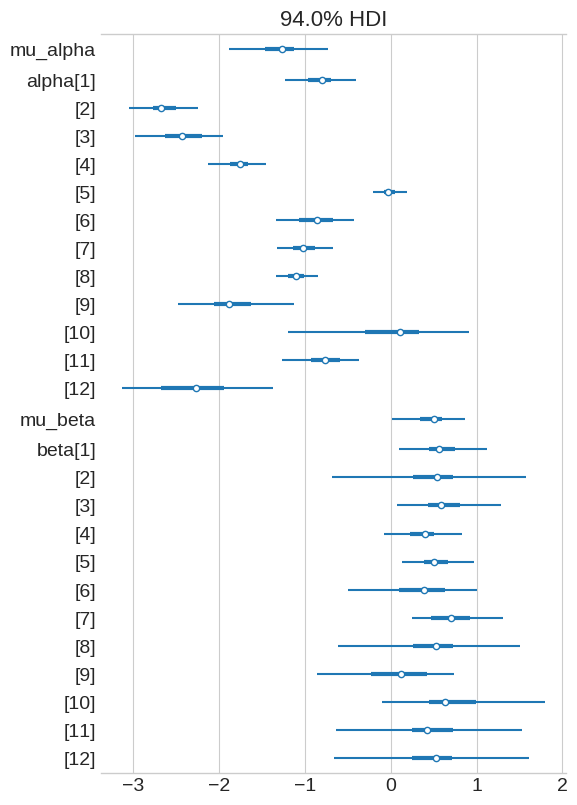

In [195]:
az.plot_forest(drawsDS2, var_names = ["mu_alpha","alpha","mu_beta","beta"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

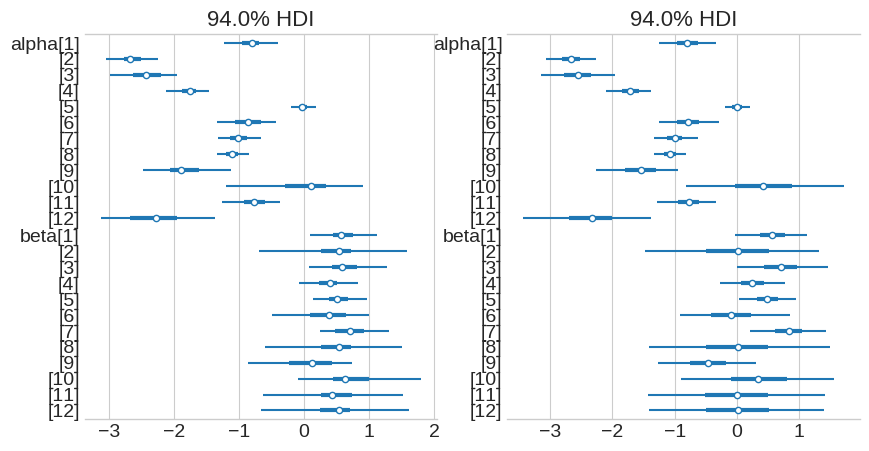

In [197]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# plot the partial pooling forest on the left-side
az.plot_forest(drawsDS2, var_names =  ["alpha","beta"], ax=axs[0])

# plot the no pooling forest on the right side
az.plot_forest(drawsDS, var_names = ["alpha","beta"], ax=axs[1])

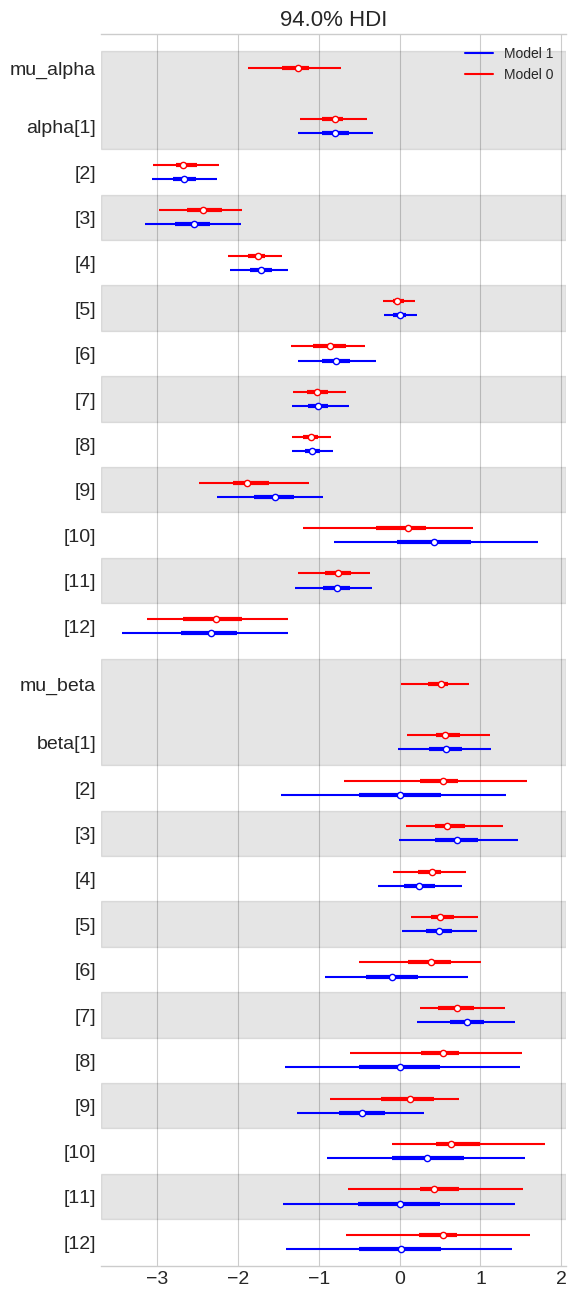

In [199]:
import arviz as az

# create the colors list
colors = ["red", "blue"]

# plot the data with different colors
az.plot_forest([drawsDS2, drawsDS], var_names =  ["mu_alpha","alpha","mu_beta","beta"], combined=True, colors=colors)

# show the plot
plt.show()


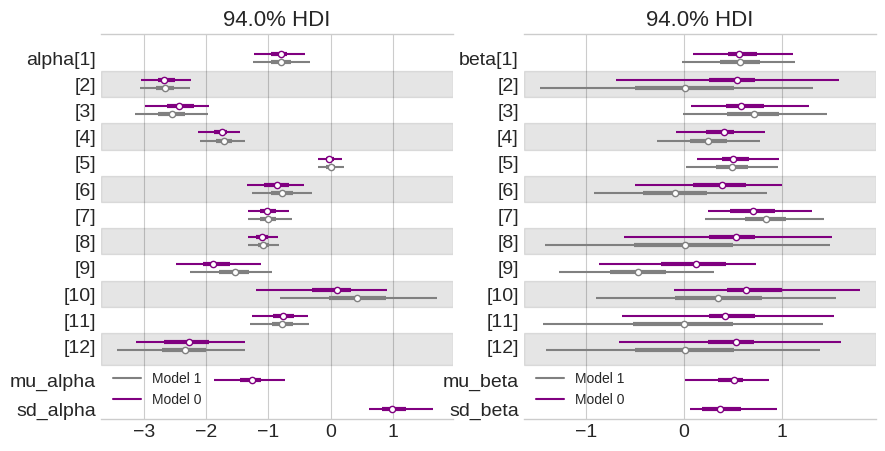

In [208]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# create the colors list
colors = ["purple", "grey"]

# plot the data with different colors
az.plot_forest([drawsDS2, drawsDS], var_names =  "alpha", filter_vars="like", combined=True, colors=colors, ax=axs[0])
az.plot_forest([drawsDS2, drawsDS], var_names =  "beta", filter_vars="like", combined=True, colors=colors, ax=axs[1])

# show the plot
plt.show()

<Axes: xlabel='k / k'>

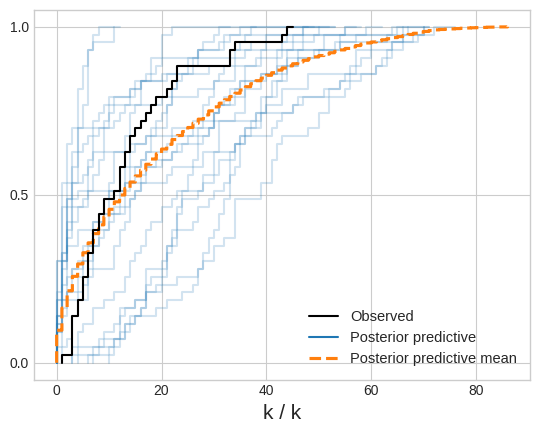

In [207]:
rng = random.PRNGKey(seed = 111)

## Predictive is a NumPyro class used to construct posterior distributions
predictiveObject = Predictive(model = partialPoolingModel,posterior_samples = postSamples)

## now make posterior predictions
## use None for data so that it gets simulated from posterior draws
postPredData = predictiveObject(
    rng_key, 
    x = gymDF.yogaStretch.values,
    j = pd.factorize(gymDF.gymID.values)[0], ## ensure compatibility with python 
                                             ## zero-based indexing
    nTrials = gymDF.nTrialCustomers.values, 
    k = None,
    numObs = len(gymDF.nSigned.values)
)
postPredData  ## for each of 4,000 draws, 
              ## get 44 simulated observations of gyms

dataForArvizPlotting = az.from_numpyro(
    posterior = mcmc,
    posterior_predictive=postPredData
)
az.plot_ppc(dataForArvizPlotting, num_pp_samples=20, kind = "cumulative")